In [15]:
import sys

sys.path.append('..')

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import spacy
import re
import json

from helpers.utils import (
    tokenize
)

# progress bar
tqdm.pandas()

In [2]:
nlp_core = spacy.load("pl_core_news_lg")

stopwords = nlp_core.Defaults.stop_words

## Load data

In [3]:
df = pd.read_parquet('../datasets/ready2use/fake_news_features_combined.parquet')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment']
X_train = df.copy().loc[:, df.columns != 'assestment']

In [4]:
y_train.value_counts()

assestment
0    3439
1    3103
Name: count, dtype: int64

## Analysis words frequencies

In [5]:
X_train['words']  = X_train['text_clean'].progress_map(lambda x: tokenize(txt=x, nlp_core=nlp_core, stopwords=stopwords))

X_train = X_train[X_train['words'].apply(len)>0]
y_train = y_train[y_train.index.isin(X_train.index)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6542/6542 [00:51<00:00, 126.08it/s]


In [8]:
df_one = X_train.copy()

df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

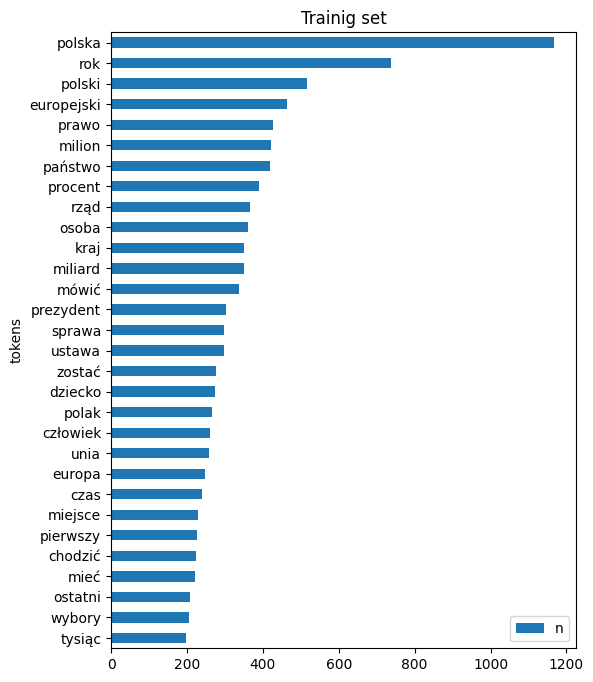

In [20]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8))
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

## Extra stopwords

In [12]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'polski', 'europejski', 'milion',
                        'prawo', 'państwo', 
                        'procent', 'rząd', 'miliard', 'osoba', 'kraj', 'mowić'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [14]:
len(extra_stop_words)

10455

In [18]:
extra_stop_words_dict = {'extra_stop_words' : list(extra_stop_words)}

In [19]:
with open("../datasets/ready2use/extra_stop_words.json", "w") as fp:
    json.dump(extra_stop_words_dict, fp) 